In this notebook there is the usage of the function: <b>dadi.Plotting.plot_1d_comp_multinomial</b>:


This function plot a comparison between a one-dimensional model and data FS. 

In the multinomial method, the model is optimally scaled to match the data. The top plot shows the model and data frequency spectra, while the bottom shows the residuals between model and data. The bottom plot shows the residuals between model and data; a positive residuals means the model predicts too many SNPs in that entry.
The residuals are the properly normalized differences between model and data. Normalization is necessary, because the expected variance in each entry increase with the expected value of that entry.

In [7]:
%run imports.ipynb

In [8]:
import dadi
from dadi import Numerics
from dadi import PhiManip
from dadi import Integration
from dadi import Spectrum
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import pylab

In [3]:
callset = callset_biallel
accessibility_fn = accessibility
contigs = ('3R')

In [4]:
allele_counts = zarr.open('data/phase2_biallel_allele_count.zarr/')
list(allele_counts['3L'].keys())

['AOcol',
 'BFcol',
 'BFgam',
 'CIcol',
 'CMgam',
 'FRgam',
 'GAgam',
 'GHcol',
 'GHgam',
 'GM',
 'GNcol',
 'GNgam',
 'GQgam',
 'GW',
 'KE',
 'UGgam']

In [6]:
outgroup_alleles = h5py.File('data/outgroup_alleles_phase2.h5', mode = 'r')
annotation = zarr.open('data/ag1000g.phase2.ar1.pass.biallelic_snpeff/')

In [16]:
def two_epoch(params, ns, pts):
    nu1, T1, p_misid = [1, 1, 0.01]

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    phi = Integration.one_pop(phi, xx, T1, nu1)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return (1 - p_misid) * fs + p_misid * dadi.Numerics.reverse_array(fs)


def three_epoch(params, ns, pts):
    nu1, nu2, T1, T2, p_misid = [1, 1, 1, 1, 0.01]

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    phi = Integration.one_pop(phi, xx, T1, nu1)
    phi = Integration.one_pop(phi, xx, T2, nu2)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return (1 - p_misid) * fs + p_misid * dadi.Numerics.reverse_array(fs)

def four_epoch(params, ns, pts):
    nu1, nu2, nu3, T1, T2, T3, p_misid = [1, 1, 1, 1, 1, 1, 0.01]

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    phi = Integration.one_pop(phi, xx, T1, nu1)
    phi = Integration.one_pop(phi, xx, T2, nu2)
    phi = Integration.one_pop(phi, xx, T3, nu3)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return (1 - p_misid) * fs + p_misid * dadi.Numerics.reverse_array(fs)

def three_exp(params, ns, pts):
    nu1, nu2, T1, T2, p_misid = [1, 1, 1, 1, 0.01]

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx)

    phi = Integration.one_pop(phi, xx, T1, nu1)
    nu_func = lambda t: numpy.exp(numpy.log(nu2) * t/T )
    phi = Integration.one_pop(phi, xx, T2, nu_func)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return (1 - p_misid) * fs + p_misid * dadi.Numerics.reverse_array(fs)
simul = {'two_epoch': two_epoch, 'three_epoch': three_epoch, 'three_exp': three_exp, 'four_epoch': four_epoch}

def implem(pop_name, k, fs, pts):


    if k == "two_epoch":
        params=[1, 1, 0.01]
        lower_bound=[0.1, 0.01, 0.001]
        upper_bound=[100, 10, 0.1]

    elif k == "three_epoch" or k == "three_exp":
        params=[1, 1, 1, 1, 0.01]
        lower_bound=[0.1, 0.1, 0.01, 0.01, 0.001]
        upper_bound=[100, 100, 10, 10, 0.1]

    elif k == "four_epoch":
        params=[1, 1, 1, 1, 1, 1, 0.01]
        lower_bound=[0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.001]
        upper_bound=[100, 100, 100, 10, 10, 10, 0.1]


    func = simul[k]
    ns = fs.sample_sizes
    func_ex = dadi.Numerics.make_extrap_log_func(func)

    l = list()
    for i in range(50): ##prima era 50
        p0 = dadi.Misc.perturb_params(params, fold=1.5, lower_bound=lower_bound, upper_bound=upper_bound)

        popt = dadi.Inference.optimize_log(p0, fs, func_ex, pts, lower_bound=lower_bound, upper_bound=upper_bound,
                                           verbose=len(params), maxiter=300, multinom=True) #verbose era 0
        model = func_ex(popt, ns, pts)
        ll_opt = dadi.Inference.ll_multinom(model, fs)
        summary = [float(ll_opt), np.array(popt).tolist(), model]
        l.append(summary)
        ###print (popt)

    array_l = np.asarray(l, dtype=object)
    #best = [ll_opt, [params]]
    best = array_l[np.argmax(array_l[:, 0], axis=0), :2]
    print ('Popolazione:', pop_name)
    model = array_l[np.argmax(array_l[:, 0], axis=0), -1]
    theta0 = dadi.Inference.optimal_sfs_scaling(model, fs)
    Na = (theta0 / 30001805) / (4. * 3.5e-9)
    generation = 0.09



    with open('dadi/output_files/%s_%s.txt' % (k,pop_name),
              'w') as outf:
        writer = csv.writer(outf, delimiter='\t')

        if k == "two_epoch":

            N1 = best[1][0] * Na
            T1 = best[1][1] * (2 * Na * generation)

            header = ['ll_opt', 'theta', 'Na', 'N1', 'T1', 'parameters']
            writer.writerow(header)
            row = [best[0], theta0, Na, N1, T1, best[1]]
            writer.writerow(row)

        elif k == "three_epoch" or k == "three_exp":

            N1 = best[1][0] * Na
            N2 = best[1][1] * Na
            
            T1 = best[1][0] * (2 * Na * generation)
            T2 = best[1][1] * (2 * Na * generation)
            header = ['ll_opt', 'theta', 'Na', 'N1', 'N2', 'T1(lenght)', 'T2', 'parameters']
            writer.writerow(header)
            row = [best[0], theta0, Na, N1, N2, T1, T2, best[1]]
            writer.writerow(row)

        elif k == "four_epoch":

            N1 = best[1][0] * Na
            N2 = best[1][1] * Na
            N3 = best[1][2] * Na
            T1 = best[1][3] * (2 * Na * generation)
            T2 = best[1][4] * (2 * Na * generation)
            T3 = best[1][5] * (2 * Na * generation)

            header = ['ll_opt', 'theta', 'Na', 'N1', 'N2', 'N3' 'T1(lenght)', 'T2(lenght)', 'T3', 'parameters']
            writer.writerow(header)
            row = [best[0], theta0, Na, N1, N2, T1, T2, best[1]]
            writer.writerow(row)


    fig, ax = plt.subplots(figsize = (12,7))
    ax.set_title('Dadi %s model for %s' % (k, pop_name))
    ax.set_ylabel('log(count of sites)')
    ax.set_xlabel('Population Frequency')
    sns.despine(ax=ax, offset=10)
    dadi.Plotting.plot_1d_comp_multinom(model, fs)
    fig.savefig('dadi/plot/%s_%s.png' % (k, pop_name))

In [230]:
df = etl.fromcsv("dadi/sf_single/KE.tab", delimiter=" ")
fs = [int(float(i)) for i in df[1]]

In [231]:
fs = dadi.Spectrum(fs)
sz = fs.sample_sizes[0]
pts = np.array([sz + 30, sz + 40, sz + 50])
sz, pts

(94, array([124, 134, 144]))

13791   , -41864.3    , array([ 1.32628    ,  0.695419   ,  0.00517654 ])
13794   , -41864.3    , array([ 2.32654    ,  2.58732    ,  0.0192047  ])
13797   , -41864.3    , array([ 2.32654    ,  2.58732    ,  0.0192239  ])
13800   , -41864.3    , array([ 2.39409    ,  0.734948   ,  0.0113093  ])
13803   , -41864.3    , array([ 2.39169    ,  0.734948   ,  0.0113093  ])
13806   , -41864.3    , array([ 1.74042    ,  0.542561   ,  0.00500704 ])
13809   , -41864.3    , array([ 1.94354    ,  0.585865   ,  0.00918215 ])
13812   , -41864.3    , array([ 1.94354    ,  0.585865   ,  0.00919134 ])
13815   , -41864.3    , array([ 0.661576   ,  0.492446   ,  0.0214585  ])
13818   , -41864.3    , array([ 0.660914   ,  0.492446   ,  0.0214585  ])
13821   , -41864.3    , array([ 0.35973    ,  1.43793    ,  0.00976512 ])
13824   , -41864.3    , array([ 0.870018   ,  1.2723     ,  0.00519531 ])
13827   , -41864.3    , array([ 0.870018   ,  1.2723     ,  0.0052005  ])
13830   , -41864.3    , array([ 0.9985

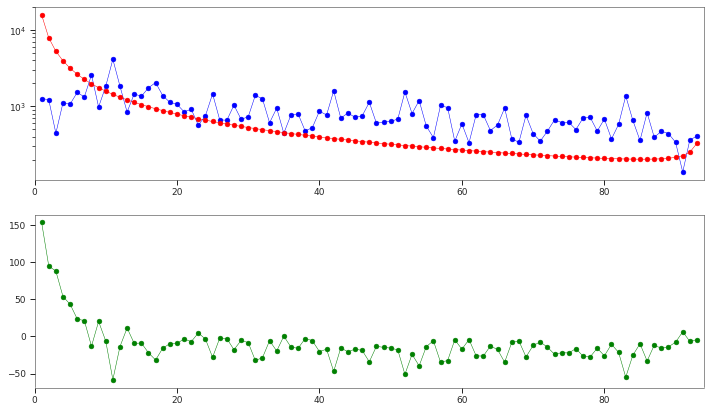

In [215]:
l = implem('KE', "two_epoch", fs, pts)

8718    , -99921.3    , array([ 1.01609    ,  0.675231   ,  0.0226883  ])
8721    , -99921.3    , array([ 1.01609    ,  0.675231   ,  0.022711   ])
8724    , -99921.3    , array([ 1.33513    ,  1.36337    ,  0.00477118 ])
8727    , -99921.3    , array([ 1.33379    ,  1.36337    ,  0.00477118 ])
8730    , -99921.3    , array([ 1.43615    ,  1.15559    ,  0.0279406  ])
8733    , -99921.3    , array([ 1.23665    ,  2.27194    ,  0.00854462 ])
8736    , -99921.3    , array([ 1.23665    ,  2.27194    ,  0.00855317 ])
8739    , -99921.3    , array([ 1.4777     ,  0.821265   ,  0.0140078  ])
8742    , -99921.3    , array([ 1.47622    ,  0.821265   ,  0.0140078  ])
8745    , -99921.3    , array([ 2.51393    ,  1.45895    ,  0.0135751  ])
8748    , -99921.3    , array([ 0.75869    ,  1.13103    ,  0.00381736 ])
8751    , -99921.3    , array([ 0.75869    ,  1.13103    ,  0.00382118 ])
8754    , -99921.3    , array([ 0.887949   ,  1.48457    ,  0.0112713  ])
8757    , -99921.3    , array([ 0.8870

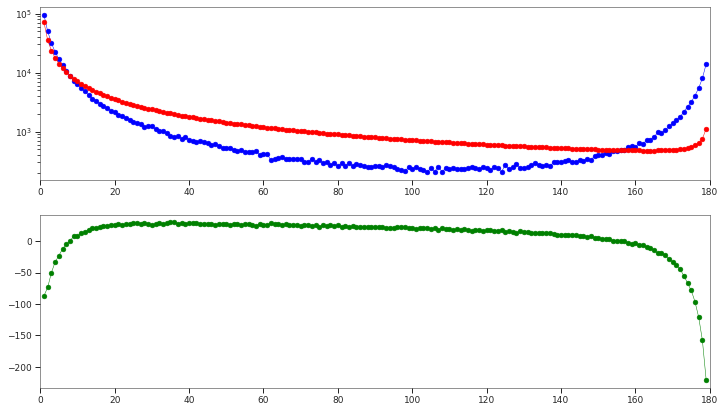

In [164]:
df = etl.fromcsv("dadi/sf_single/GW.tab", delimiter=" ")
fs = [int(float(i)) for i in df[1]]
fs = dadi.Spectrum(fs)
sz = fs.sample_sizes[0]
pts = np.array([sz + 30, sz + 40, sz + 50])
l = implem('GW', "two_epoch", fs, pts)

8970    , -62121.6    , array([ 0.707626   ,  0.809421   ,  0.00994329 ])
8973    , -62121.6    , array([ 0.481528   ,  0.377821   ,  0.00844084 ])
8976    , -62121.6    , array([ 0.481528   ,  0.377821   ,  0.00844929 ])
8979    , -62121.6    , array([ 2.15385    ,  2.1534     ,  0.00660248 ])
8982    , -62121.6    , array([ 2.1517     ,  2.1534     ,  0.00660248 ])
8985    , -62121.6    , array([ 0.735931   ,  1.58074    ,  0.010467   ])
8988    , -62121.6    , array([ 0.790666   ,  0.587503   ,  0.00781152 ])
8991    , -62121.6    , array([ 0.790666   ,  0.587503   ,  0.00781933 ])
8994    , -62121.6    , array([ 0.761103   ,  2.13136    ,  0.0112492  ])
8997    , -62121.6    , array([ 0.760342   ,  2.13136    ,  0.0112492  ])
9000    , -62121.6    , array([ 0.521461   ,  0.809586   ,  0.00640472 ])
9003    , -62121.6    , array([ 0.808519   ,  0.65927    ,  0.00381222 ])
9006    , -62121.6    , array([ 0.808519   ,  0.65927    ,  0.00381604 ])
9009    , -62121.6    , array([ 1.9998

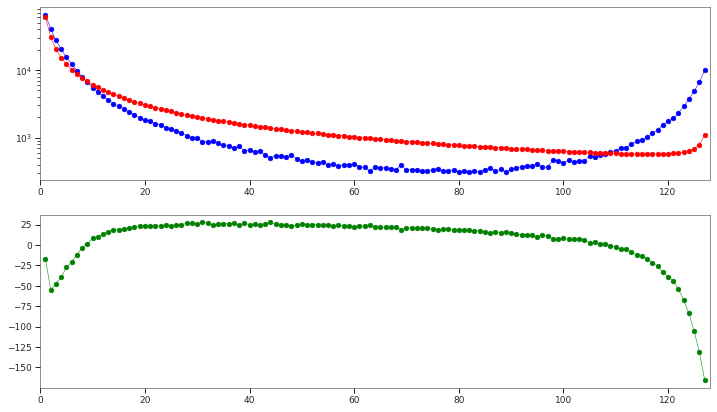

In [165]:
df = etl.fromcsv("dadi/sf_single/GM.tab", delimiter=" ")
fs = [int(float(i)) for i in df[1]]
fs = dadi.Spectrum(fs)
sz = fs.sample_sizes[0]
pts = np.array([sz + 30, sz + 40, sz + 50])
l = implem('GM', "two_epoch", fs, pts)

14040   , -60285.4    , array([ 2.38146    ,  2.13934    ,  0.00985637 ])
14043   , -60285.4    , array([ 2.37908    ,  2.13934    ,  0.00985637 ])
14046   , -60285.4    , array([ 0.505826   ,  0.54265    ,  0.0201378  ])
14049   , -60285.4    , array([ 1.39466    ,  0.844325   ,  0.00459776 ])
14052   , -60285.4    , array([ 1.39466    ,  0.844325   ,  0.00460236 ])
14055   , -60285.4    , array([ 1.51205    ,  1.3451     ,  0.0189204  ])
14058   , -60285.4    , array([ 1.51054    ,  1.3451     ,  0.0189204  ])
14061   , -60285.4    , array([ 2.40698    ,  2.47306    ,  0.0238606  ])
14064   , -60285.4    , array([ 0.428454   ,  1.34352    ,  0.0234832  ])
14067   , -60285.4    , array([ 0.428454   ,  1.34352    ,  0.0235067  ])
14070   , -60285.4    , array([ 2.51457    ,  1.75016    ,  0.0177384  ])
14073   , -60285.4    , array([ 2.51205    ,  1.75016    ,  0.0177384  ])
14076   , -60285.4    , array([ 0.446699   ,  0.818252   ,  0.0127032  ])
14079   , -60285.4    , array([ 0.3955

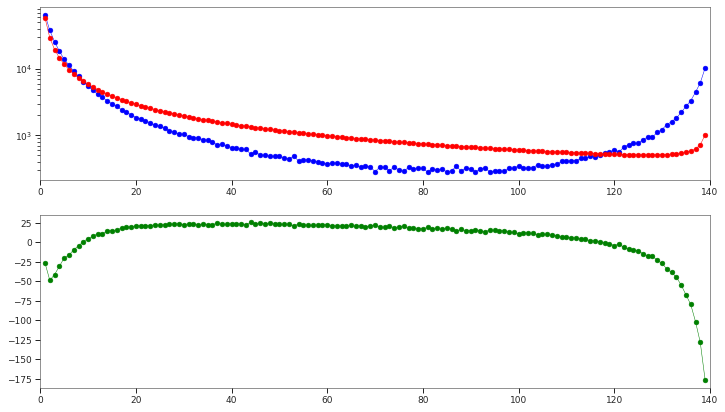

In [220]:
df = etl.fromcsv("dadi/sf_single/CIcol.tab", delimiter=" ")
fs = [int(float(i)) for i in df[1]]
fs = dadi.Spectrum(fs)
sz = fs.sample_sizes[0]
pts = np.array([sz + 30, sz + 40, sz + 50])
l = implem('CIcol', "two_epoch", fs, pts)

-------------------------------------

In [2]:
populations = ['AOcol','BFcol','BFgam','CIcol','CMgam','FRgam','GAgam','GHcol','GHgam','GM','GNcol','GNgam','GQgam','GW','KE','UGgam']

4317    , -22039.3    , array([ 1.59152    ,  0.743786   ,  0.00487492 ])
4320    , -22039.3    , array([ 1.59152    ,  0.743786   ,  0.0048798  ])
4323    , -22039.3    , array([ 0.356085   ,  0.807846   ,  0.0192848  ])
4326    , -22039.3    , array([ 0.355729   ,  0.807846   ,  0.0192848  ])
4329    , -22039.3    , array([ 0.724631   ,  1.17775    ,  0.00447168 ])
4332    , -22039.3    , array([ 2.06276    ,  0.774741   ,  0.0176372  ])
4335    , -22039.3    , array([ 2.06276    ,  0.774741   ,  0.0176549  ])
4338    , -22039.3    , array([ 1.70472    ,  0.427805   ,  0.00765778 ])
4341    , -22039.3    , array([ 1.70302    ,  0.427805   ,  0.00765778 ])
4344    , -22039.3    , array([ 1.25155    ,  0.354891   ,  0.00732128 ])
4347    , -22039.3    , array([ 1.37994    ,  0.489363   ,  0.0182822  ])
4350    , -22039.3    , array([ 1.37994    ,  0.489363   ,  0.0183005  ])
4353    , -22039.3    , array([ 0.853002   ,  1.06482    ,  0.013405   ])
4356    , -22039.3    , array([ 0.8521

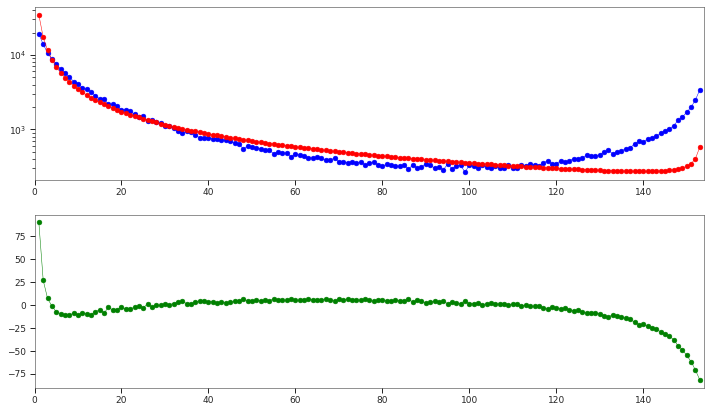

4569    , -85560.9    , array([ 2.4503     ,  1.18046    ,  0.00782675 ])
4572    , -85560.9    , array([ 0.510327   ,  1.08348    ,  0.025226   ])
4575    , -85560.9    , array([ 0.510327   ,  1.08348    ,  0.0252513  ])
4578    , -85560.9    , array([ 2.32738    ,  1.38547    ,  0.014269   ])
4581    , -85560.9    , array([ 2.32505    ,  1.38547    ,  0.014269   ])
4584    , -85560.9    , array([ 1.04449    ,  0.559656   ,  0.0145749  ])
4587    , -85560.9    , array([ 1.86393    ,  0.724048   ,  0.00782612 ])
4590    , -85560.9    , array([ 1.86393    ,  0.724048   ,  0.00783395 ])
4593    , -85560.9    , array([ 2.33682    ,  0.414803   ,  0.0275293  ])
4596    , -85560.9    , array([ 2.33449    ,  0.414803   ,  0.0275293  ])
4599    , -85560.9    , array([ 0.422161   ,  0.479039   ,  0.00446014 ])
4602    , -85560.9    , array([ 0.604214   ,  0.475835   ,  0.0152827  ])
4605    , -85560.9    , array([ 0.604214   ,  0.475835   ,  0.0152979  ])
4608    , -85560.9    , array([ 1.9860

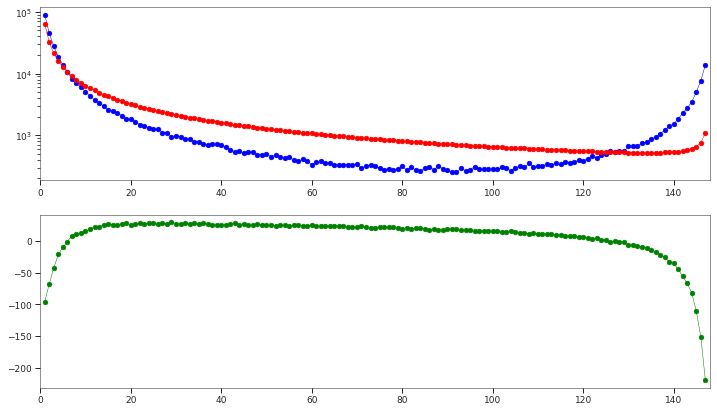

4818    , -60285.4    , array([ 1.9941     ,  1.10016    ,  0.0121217  ])
4821    , -60285.4    , array([ 1.99211    ,  1.10016    ,  0.0121217  ])
4824    , -60285.4    , array([ 0.63997    ,  0.359495   ,  0.00441799 ])
4827    , -60285.4    , array([ 1.04785    ,  1.40259    ,  0.00778151 ])
4830    , -60285.4    , array([ 1.04785    ,  1.40259    ,  0.0077893  ])
4833    , -60285.4    , array([ 0.371755   ,  0.927543   ,  0.0158922  ])
4836    , -60285.4    , array([ 0.371383   ,  0.927543   ,  0.0158922  ])
4839    , -60285.4    , array([ 0.443982   ,  0.364831   ,  0.00684077 ])
4842    , -60285.4    , array([ 1.24428    ,  1.23124    ,  0.00919041 ])
4845    , -60285.4    , array([ 1.24428    ,  1.23124    ,  0.0091996  ])
4848    , -60285.4    , array([ 2.47425    ,  1.92928    ,  0.0188911  ])
4851    , -60285.4    , array([ 2.47178    ,  1.92928    ,  0.0188911  ])
4854    , -60285.4    , array([ 0.719161   ,  2.20396    ,  0.00358583 ])
4857    , -60285.4    , array([ 0.4538

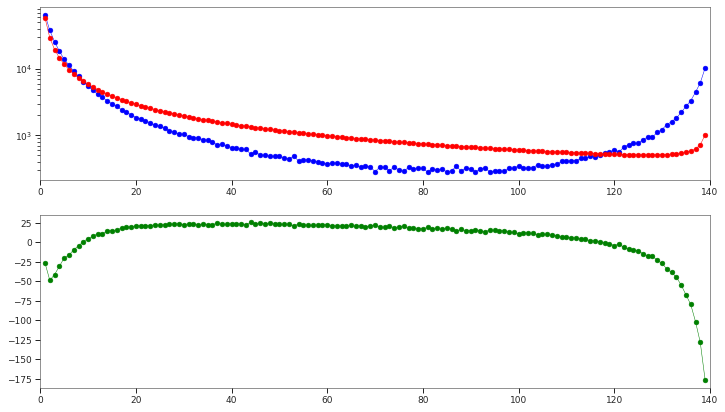

5067    , -50658.1    , array([ 1.19971    ,  0.60154    ,  0.0206368  ])
5070    , -50658.1    , array([ 1.19971    ,  0.60154    ,  0.0206575  ])
5073    , -50658.1    , array([ 0.385535   ,  1.64725    ,  0.0125453  ])
5076    , -50658.1    , array([ 0.385149   ,  1.64725    ,  0.0125453  ])
5079    , -50658.1    , array([ 1.98761    ,  0.631675   ,  0.0104466  ])
5082    , -50658.1    , array([ 1.91527    ,  2.46116    ,  0.0046537  ])
5085    , -50658.1    , array([ 1.91527    ,  2.46116    ,  0.00465835 ])
5088    , -50658.1    , array([ 0.803483   ,  0.880407   ,  0.0196225  ])
5091    , -50658.1    , array([ 0.80268    ,  0.880407   ,  0.0196225  ])
5094    , -50658.1    , array([ 1.57553    ,  0.540651   ,  0.00995582 ])
5097    , -50658.1    , array([ 2.13042    ,  0.402068   ,  0.0262037  ])
5100    , -50658.1    , array([ 2.13042    ,  0.402068   ,  0.0262299  ])
5103    , -50658.1    , array([ 0.728317   ,  1.07884    ,  0.0183299  ])
5106    , -50658.1    , array([ 0.7275

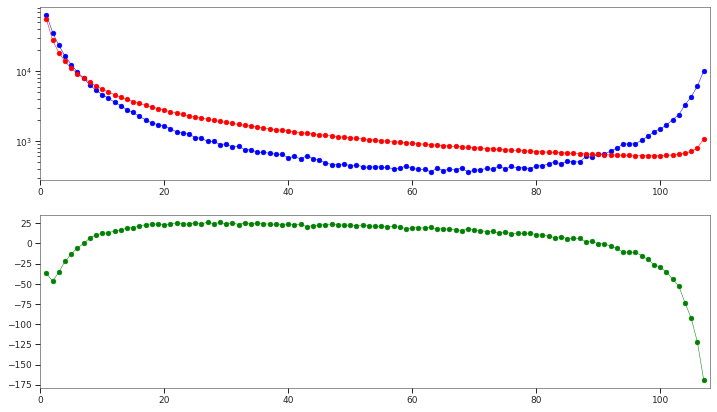

5319    , -1306.24    , array([ 0.978324   ,  2.74293    ,  0.0231048  ])
5322    , -1306.24    , array([ 0.701732   ,  0.784674   ,  0.0233113  ])
5325    , -1306.24    , array([ 0.701732   ,  0.784674   ,  0.0233346  ])
5328    , -1306.24    , array([ 0.554736   ,  1.69741    ,  0.00543714 ])
5331    , -1306.24    , array([ 0.554181   ,  1.69741    ,  0.00543714 ])
5334    , -1306.24    , array([ 1.18649    ,  0.640447   ,  0.00800693 ])
5337    , -1306.24    , array([ 0.374385   ,  0.441283   ,  0.00779958 ])
5340    , -1306.24    , array([ 0.374385   ,  0.441283   ,  0.00780739 ])
5343    , -1306.24    , array([ 0.544558   ,  0.41841    ,  0.0123555  ])
5346    , -1306.24    , array([ 0.544014   ,  0.41841    ,  0.0123555  ])
5349    , -1306.24    , array([ 1.25444    ,  1.83514    ,  0.0212119  ])
5352    , -1306.24    , array([ 0.738261   ,  0.578122   ,  0.0129905  ])
5355    , -1306.24    , array([ 0.738261   ,  0.578122   ,  0.0130035  ])
5358    , -1306.24    , array([ 1.3132

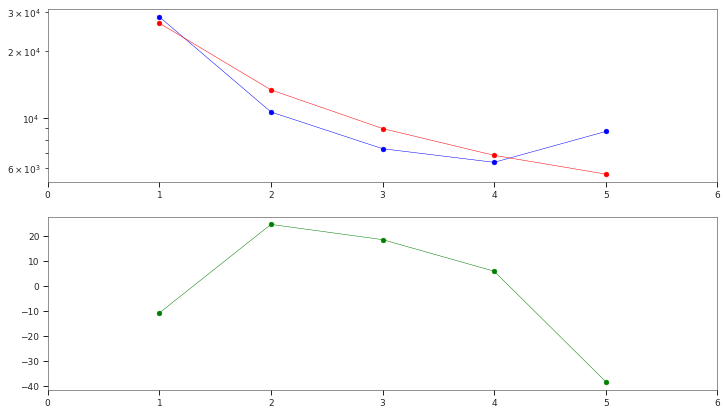

5568    , -9509.68    , array([ 1.31841    ,  0.589378   ,  0.0235104  ])
5571    , -9509.68    , array([ 1.31709    ,  0.589378   ,  0.0235104  ])
5574    , -9509.68    , array([ 1.29495    ,  0.414081   ,  0.0187485  ])
5577    , -9509.68    , array([ 0.914955   ,  1.6062     ,  0.00698709 ])
5580    , -9509.68    , array([ 0.914955   ,  1.6062     ,  0.00699408 ])
5583    , -9509.68    , array([ 1.43651    ,  1.25699    ,  0.015111   ])
5586    , -9509.68    , array([ 1.43508    ,  1.25699    ,  0.015111   ])
5589    , -9509.68    , array([ 1.41844    ,  1.25929    ,  0.00694371 ])
5592    , -9509.68    , array([ 1.64147    ,  2.18229    ,  0.00747135 ])
5595    , -9509.68    , array([ 1.64147    ,  2.18229    ,  0.00747882 ])
5598    , -9509.68    , array([ 2.37964    ,  2.56485    ,  0.0174195  ])
5601    , -9509.68    , array([ 2.37727    ,  2.56485    ,  0.0174195  ])
5604    , -9509.68    , array([ 1.4861     ,  1.63848    ,  0.0145355  ])
5607    , -9509.68    , array([ 0.7474

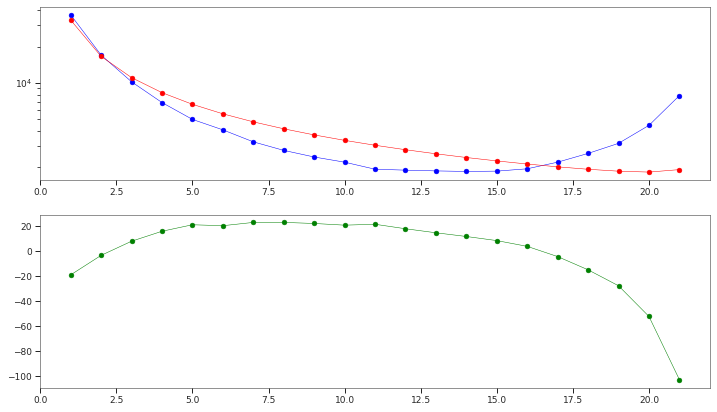

5817    , -323778     , array([ 0.648846   ,  1.75723    ,  0.0193904  ])
5820    , -323778     , array([ 0.648846   ,  1.75723    ,  0.0194098  ])
5823    , -323778     , array([ 1.82105    ,  0.373092   ,  0.0177549  ])
5826    , -323778     , array([ 1.81923    ,  0.373092   ,  0.0177549  ])
5829    , -323778     , array([ 0.386565   ,  1.52023    ,  0.00744949 ])
5832    , -323778     , array([ 0.760623   ,  0.983365   ,  0.0156053  ])
5835    , -323778     , array([ 0.760623   ,  0.983365   ,  0.0156209  ])
5838    , -323778     , array([ 1.01614    ,  1.4257     ,  0.00761487 ])
5841    , -323778     , array([ 1.01512    ,  1.4257     ,  0.00761487 ])
5844    , -323778     , array([ 0.592235   ,  0.546075   ,  0.00639801 ])
5847    , -323778     , array([ 1.66577    ,  1.28089    ,  0.0219151  ])
5850    , -323778     , array([ 1.66577    ,  1.28089    ,  0.021937   ])
5853    , -323778     , array([ 1.06049    ,  0.78508    ,  0.00407497 ])
5856    , -323778     , array([ 1.0594

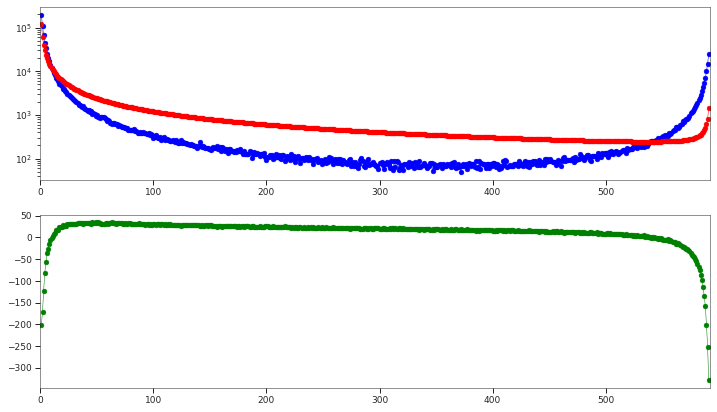

6069    , -118924     , array([ 0.615503   ,  0.762473   ,  0.0120865  ])
6072    , -118924     , array([ 0.80809    ,  0.518894   ,  0.0156207  ])
6075    , -118924     , array([ 0.80809    ,  0.518894   ,  0.0156364  ])
6078    , -118924     , array([ 0.727132   ,  0.899537   ,  0.0100784  ])
6081    , -118924     , array([ 0.726405   ,  0.899537   ,  0.0100784  ])
6084    , -118924     , array([ 0.456213   ,  0.355733   ,  0.00363786 ])
6087    , -118924     , array([ 2.09787    ,  1.25433    ,  0.00441382 ])
6090    , -118924     , array([ 2.09787    ,  1.25433    ,  0.00441824 ])
6093    , -118924     , array([ 0.556632   ,  0.49113    ,  0.011101   ])
6096    , -118924     , array([ 0.556075   ,  0.49113    ,  0.011101   ])
6099    , -118924     , array([ 0.85125    ,  2.74736    ,  0.00663192 ])
6102    , -118924     , array([ 2.33831    ,  0.664025   ,  0.00666136 ])
6105    , -118924     , array([ 2.33831    ,  0.664025   ,  0.00666803 ])
6108    , -118924     , array([ 0.6869

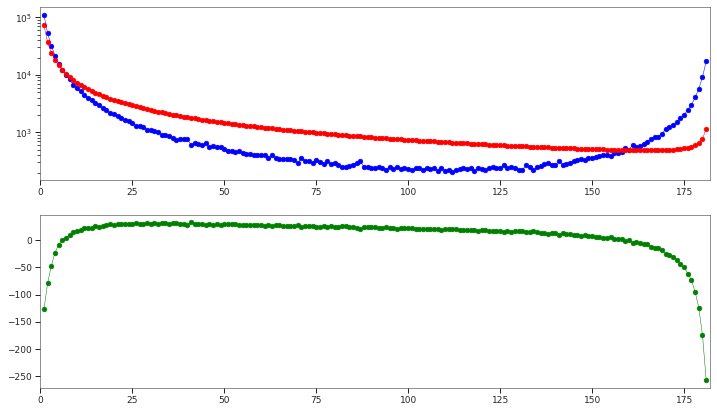

6318    , -50780.6    , array([ 1.84427    ,  2.38695    ,  0.00382639 ])
6321    , -50780.6    , array([ 1.84243    ,  2.38695    ,  0.00382639 ])
6324    , -50780.6    , array([ 0.596913   ,  1.94185    ,  0.0161871  ])
6327    , -50780.6    , array([ 0.422718   ,  0.751752   ,  0.00717194 ])
6330    , -50780.6    , array([ 0.422718   ,  0.751752   ,  0.00717912 ])
6333    , -50780.6    , array([ 1.16436    ,  0.455568   ,  0.00843552 ])
6336    , -50780.6    , array([ 1.16319    ,  0.455568   ,  0.00843552 ])
6339    , -50780.6    , array([ 0.801992   ,  0.564759   ,  0.00536752 ])
6342    , -50780.6    , array([ 2.52445    ,  0.872837   ,  0.016094   ])
6345    , -50780.6    , array([ 2.52445    ,  0.872837   ,  0.0161101  ])
6348    , -50780.6    , array([ 1.83538    ,  1.70558    ,  0.0208039  ])
6351    , -50780.6    , array([ 1.83354    ,  1.70558    ,  0.0208039  ])
6354    , -50780.6    , array([ 0.490578   ,  2.41657    ,  0.00826779 ])
6357    , -50780.6    , array([ 1.3335

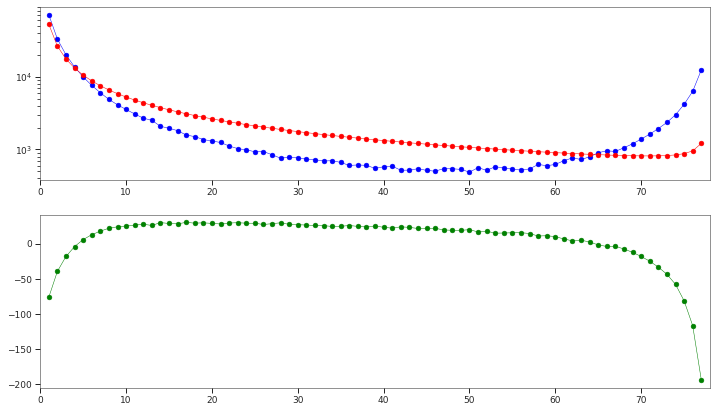

6567    , -4117.22    , array([ 0.892472   ,  0.967475   ,  0.0262151  ])
6570    , -4117.22    , array([ 0.892472   ,  0.967475   ,  0.0262413  ])
6573    , -4117.22    , array([ 2.83039    ,  1.36458    ,  0.00492526 ])
6576    , -4117.22    , array([ 2.82756    ,  1.36458    ,  0.00492526 ])
6579    , -4117.22    , array([ 0.473626   ,  0.484163   ,  0.0048874  ])
6582    , -4117.22    , array([ 0.359792   ,  1.37376    ,  0.00907117 ])
6585    , -4117.22    , array([ 0.359792   ,  1.37376    ,  0.00908025 ])
6588    , -4117.22    , array([ 0.41861    ,  0.430029   ,  0.0139817  ])
6591    , -4117.22    , array([ 0.418191   ,  0.430029   ,  0.0139817  ])
6594    , -4117.22    , array([ 0.522268   ,  1.22335    ,  0.00400323 ])
6597    , -4117.22    , array([ 1.13636    ,  1.64584    ,  0.00944264 ])
6600    , -4117.22    , array([ 1.13636    ,  1.64584    ,  0.00945208 ])
6603    , -4117.22    , array([ 2.59778    ,  1.42898    ,  0.023497   ])
6606    , -4117.22    , array([ 2.5951

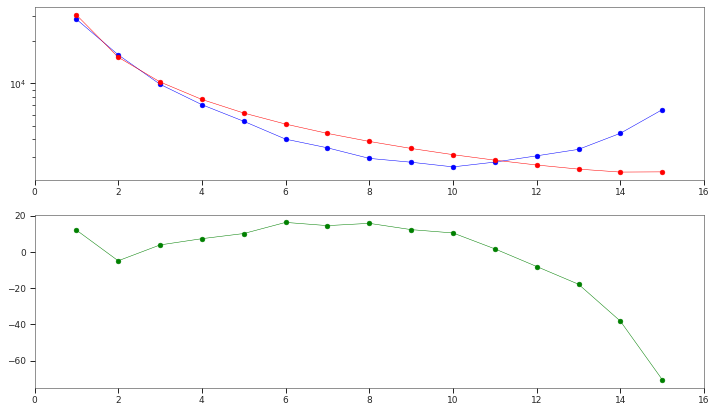

6819    , -129079     , array([ 0.669726   ,  1.26071    ,  0.0038017  ])
6822    , -129079     , array([ 0.405575   ,  2.14237    ,  0.00484939 ])
6825    , -129079     , array([ 0.405575   ,  2.14237    ,  0.00485424 ])
6828    , -129079     , array([ 2.40444    ,  1.17148    ,  0.00363574 ])
6831    , -129079     , array([ 2.40203    ,  1.17148    ,  0.00363574 ])
6834    , -129079     , array([ 1.94761    ,  1.53091    ,  0.00495026 ])
6837    , -129079     , array([ 1.29903    ,  0.559974   ,  0.00360283 ])
6840    , -129079     , array([ 1.29903    ,  0.559974   ,  0.00360643 ])
6843    , -129079     , array([ 1.72551    ,  2.29341    ,  0.0217504  ])
6846    , -129079     , array([ 1.72379    ,  2.29341    ,  0.0217504  ])
6849    , -129079     , array([ 1.4693     ,  1.90822    ,  0.0262454  ])
6852    , -129079     , array([ 2.73603    ,  2.34267    ,  0.00383966 ])
6855    , -129079     , array([ 2.73603    ,  2.34267    ,  0.0038435  ])
6858    , -129079     , array([ 1.3403

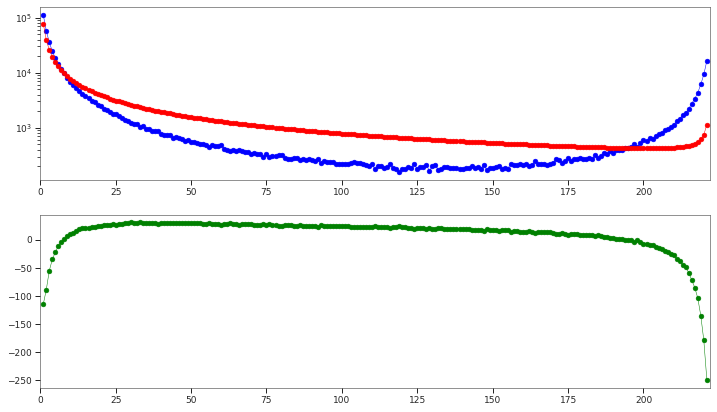

7068    , -27399.7    , array([ 1.40598    ,  2.04891    ,  0.00825937 ])
7071    , -27399.7    , array([ 1.40458    ,  2.04891    ,  0.00825937 ])
7074    , -27399.7    , array([ 0.857723   ,  0.413992   ,  0.019642   ])
7077    , -27399.7    , array([ 0.851031   ,  1.14985    ,  0.0242085  ])
7080    , -27399.7    , array([ 0.851031   ,  1.14985    ,  0.0242327  ])
7083    , -27399.7    , array([ 0.82344    ,  2.03971    ,  0.0186467  ])
7086    , -27399.7    , array([ 0.822617   ,  2.03971    ,  0.0186467  ])
7089    , -27399.7    , array([ 1.45918    ,  0.935428   ,  0.0110751  ])
7092    , -27399.7    , array([ 1.436      ,  1.03959    ,  0.00557526 ])
7095    , -27399.7    , array([ 1.436      ,  1.03959    ,  0.00558084 ])
7098    , -27399.7    , array([ 1.06087    ,  1.6997     ,  0.00618361 ])
7101    , -27399.7    , array([ 1.05981    ,  1.6997     ,  0.00618361 ])
7104    , -27399.7    , array([ 1.83652    ,  0.714071   ,  0.00703195 ])
7107    , -27399.7    , array([ 2.6968

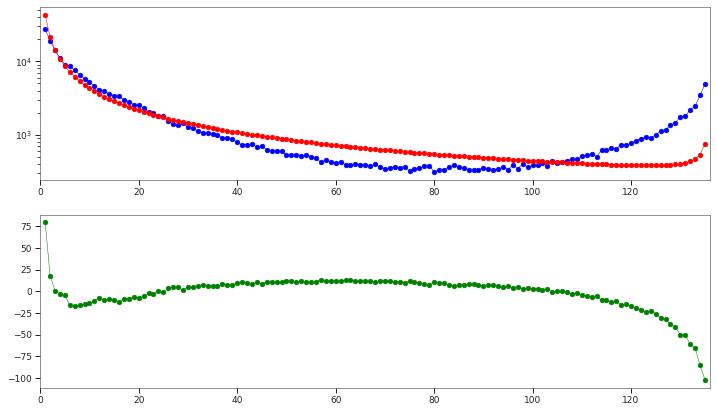

7317    , -16130.7    , array([ 0.443607   ,  0.951492   ,  0.0181148  ])
7320    , -16130.7    , array([ 0.443607   ,  0.951492   ,  0.0181329  ])
7323    , -16130.7    , array([ 2.56763    ,  0.882807   ,  0.004119   ])
7326    , -16130.7    , array([ 2.56507    ,  0.882807   ,  0.004119   ])
7329    , -16130.7    , array([ 0.459128   ,  0.586633   ,  0.00442167 ])
7332    , -16130.7    , array([ 0.700898   ,  1.4751     ,  0.0232032  ])
7335    , -16130.7    , array([ 0.700898   ,  1.4751     ,  0.0232264  ])
7338    , -16130.7    , array([ 2.60087    ,  0.442587   ,  0.00511836 ])
7341    , -16130.7    , array([ 2.59827    ,  0.442587   ,  0.00511836 ])
7344    , -16130.7    , array([ 0.697292   ,  0.635162   ,  0.0136633  ])
7347    , -16130.7    , array([ 0.502417   ,  2.30632    ,  0.0214702  ])
7350    , -16130.7    , array([ 0.502417   ,  2.30632    ,  0.0214917  ])
7353    , -16130.7    , array([ 1.45482    ,  2.52543    ,  0.0104046  ])
7356    , -16130.7    , array([ 1.4533

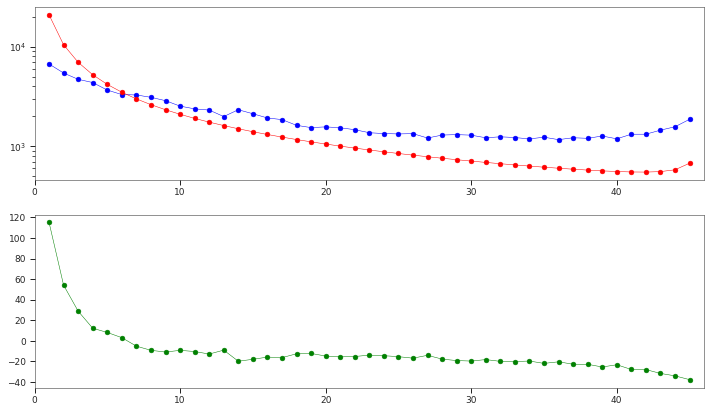

7569    , -41864.3    , array([ 1.6435     ,  0.577574   ,  0.0105494  ])
7572    , -41864.3    , array([ 2.46765    ,  2.62343    ,  0.00562548 ])
7575    , -41864.3    , array([ 2.46765    ,  2.62343    ,  0.00563111 ])
7578    , -41864.3    , array([ 0.757717   ,  2.54489    ,  0.0147182  ])
7581    , -41864.3    , array([ 0.75696    ,  2.54489    ,  0.0147182  ])
7584    , -41864.3    , array([ 1.24542    ,  2.38589    ,  0.00984462 ])
7587    , -41864.3    , array([ 0.356141   ,  2.71536    ,  0.00865425 ])
7590    , -41864.3    , array([ 0.356141   ,  2.71536    ,  0.00866291 ])
7593    , -41864.3    , array([ 2.32418    ,  0.885914   ,  0.00501533 ])
7596    , -41864.3    , array([ 2.32186    ,  0.885914   ,  0.00501533 ])
7599    , -41864.3    , array([ 0.372971   ,  0.948044   ,  0.0195439  ])
7602    , -41864.3    , array([ 1.3565     ,  1.38681    ,  0.00450174 ])
7605    , -41864.3    , array([ 1.3565     ,  1.38681    ,  0.00450625 ])
7608    , -41864.3    , array([ 2.0322

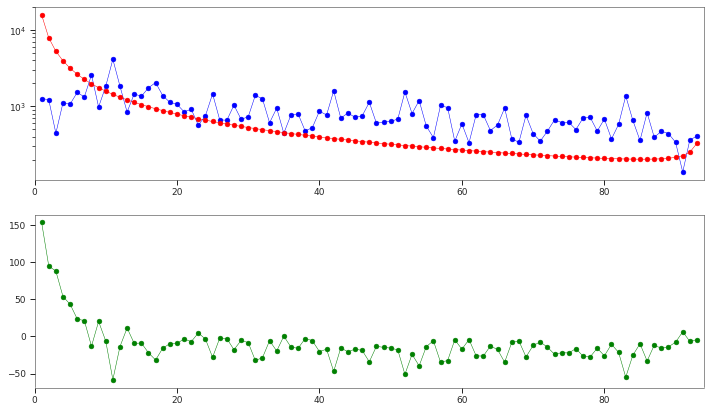

7818    , -62121.6    , array([ 0.760571   ,  0.447313   ,  0.0105701  ])
7821    , -62121.6    , array([ 0.759811   ,  0.447313   ,  0.0105701  ])
7824    , -62121.6    , array([ 0.552899   ,  1.16902    ,  0.0204853  ])
7827    , -62121.6    , array([ 0.508499   ,  1.0242     ,  0.0238433  ])
7830    , -62121.6    , array([ 0.508499   ,  1.0242     ,  0.0238671  ])
7833    , -62121.6    , array([ 0.759399   ,  0.537867   ,  0.0208009  ])
7836    , -62121.6    , array([ 0.75864    ,  0.537867   ,  0.0208009  ])
7839    , -62121.6    , array([ 1.14944    ,  1.2912     ,  0.0217848  ])
7842    , -62121.6    , array([ 1.39858    ,  2.42945    ,  0.00480855 ])
7845    , -62121.6    , array([ 1.39858    ,  2.42945    ,  0.00481337 ])
7848    , -62121.6    , array([ 0.503625   ,  2.54394    ,  0.0201467  ])
7851    , -62121.6    , array([ 0.503122   ,  2.54394    ,  0.0201467  ])
7854    , -62121.6    , array([ 1.07441    ,  1.50251    ,  0.020965   ])
7857    , -62121.6    , array([ 0.7063

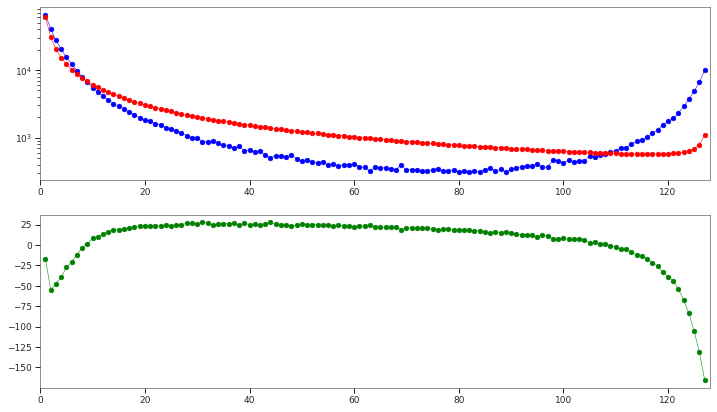

8067    , -99921.3    , array([ 1.17655    ,  1.4435     ,  0.0101861  ])
8070    , -99921.3    , array([ 1.17655    ,  1.4435     ,  0.0101962  ])
8073    , -99921.3    , array([ 0.356291   ,  0.451586   ,  0.0104547  ])
8076    , -99921.3    , array([ 0.355935   ,  0.451586   ,  0.0104547  ])
8079    , -99921.3    , array([ 1.19222    ,  0.858522   ,  0.00660557 ])
8082    , -99921.3    , array([ 1.07115    ,  1.97094    ,  0.00628185 ])
8085    , -99921.3    , array([ 1.07115    ,  1.97094    ,  0.00628814 ])
8088    , -99921.3    , array([ 0.44931    ,  0.446568   ,  0.0208872  ])
8091    , -99921.3    , array([ 0.448861   ,  0.446568   ,  0.0208872  ])
8094    , -99921.3    , array([ 2.07602    ,  1.60149    ,  0.0118165  ])
8097    , -99921.3    , array([ 0.444508   ,  1.23964    ,  0.00597394 ])
8100    , -99921.3    , array([ 0.444508   ,  1.23964    ,  0.00597992 ])
8103    , -99921.3    , array([ 0.534505   ,  0.746472   ,  0.00558043 ])
8106    , -99921.3    , array([ 0.5339

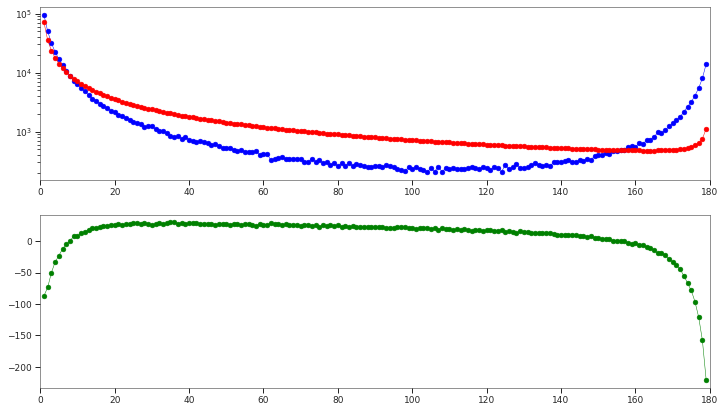

In [17]:
for pop in populations:
    
    df = etl.fromcsv("dadi/sf_single/%s.tab" % (pop), delimiter=" ")
    fs = [int(float(i)) for i in df[1]]
    fs = dadi.Spectrum(fs)
    sz = fs.sample_sizes[0]
    pts = np.array([sz + 30, sz + 40, sz + 50])
    l = implem(pop, "two_epoch", fs, pts)